In [0]:
from google.colab import drive

drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


Import pre-trained VGG16 model

In [0]:
#from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import (VGG16, preprocess_input, decode_predictions)
import os
from keras.preprocessing import image
from keras.layers.core import Lambda
from keras.models import Sequential
from tensorflow.python.framework import ops
import keras.backend as K
import tensorflow as tf
import numpy as np
import keras
import sys
import scipy.ndimage
import cv2
import matplotlib.pyplot as plt
from PIL import Image

CURR_DIR = "/content/drive/My Drive/input_analysis"

# load the model
model = VGG16(weights='imagenet')

Visualize VGG16 layers

In [0]:
model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

/usr/local/lib/python3.6/dist-packages/PIL/Image.py:914: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


(694, 1520)


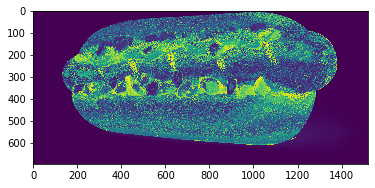

In [0]:
def load_image(path):
    img_path = path
    img = image.load_img(img_path, target_size=(224, 224))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    return x

img = load_image(os.path.join(CURR_DIR, 'hotdog.png'))
original = Image.open(os.path.join(CURR_DIR, 'hotdog.png'))
original = np.array(original)
#plt.imshow(img[0])
plt.imshow(original)
print(original.shape)

In [0]:
predictions = model.predict(img)
top_1 = decode_predictions(predictions)[0][0]
print('Predicted class:')
print('%s (%s) with probability %.2f' % (top_1[1], top_1[0], top_1[2]))
predicted_class = np.argmax(predictions)

Predicted class:
hotdog (n07697537) with probability 1.00


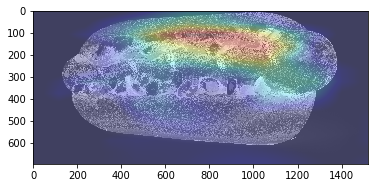

In [0]:
from keras import backend as K
from vis.utils import utils
import cv2

def grad_cam(predicted_class, img, original, savepath):
  # print(model.output)
  class_output = model.output[:,predicted_class]
  #print(class_output)

  # layer output
  convolution_output = model.get_layer('block5_conv3').output

  # get gradients
  grads = K.gradients(class_output, convolution_output)[0]

  # get convolution output and gradients for input
  gradient_function = K.function([model.input], [convolution_output, grads])

  #output, grads_val = gradient_function([(x_test[0])[np.newaxis,...]])
  output, grads_val = gradient_function([img])
  output, grads_val = output[0], grads_val[0]
  
  weights = np.mean(grads_val, axis=tuple(range(grads_val.ndim-1)))
  
  cam = np.dot(output, weights)
  
  # create heat map
  x_scale = original.shape[0] / cam.shape[0]
  y_scale = original.shape[1] / cam.shape[1]
  cam = scipy.ndimage.zoom(cam, (x_scale,y_scale), order=1)

  cam = np.maximum(cam, 0)

  plt.imshow(cam, cmap = 'jet', alpha = 0.5)
  plt.imshow(original, cmap = 'gray', alpha = 0.5)
  plt.savefig(os.path.join(CURR_DIR, savepath))
  
grad_cam(predicted_class, img, original, "hotdog_cam.jpg")